# HW11: Variance Reduction

## Preliminaries

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.optimize as optimize

### Random Seed

In [3]:
seed=734903
rng=np.random.default_rng(seed)

### Code

#### Market Data Objects

##### Discount

In [4]:
class Discount:
    def __init__(self,ts,rates):
        self.ts=ts
        self.rates=rates
    def __call__(self,T):
        r=np.interp(T,self.ts,self.rates)
        return np.exp(-r*T)


 ##### Forwards

In [5]:
class Forward:
    def __init__(self,spot,discount,dividends):
        self.spot=spot
        self.discount=discount
        self.dividends=dividends
    def __call__(self,T):
        Df_r=self.discount(T)
        Df_d=self.dividends(T)
        return self.spot*Df_d/Df_r

##### SVI Volatility Surface
<a id="svi"/>

In [6]:
        
class SVI:
    def __init__(self,ref_fwd,ts,a,b,rho,m,sigma):
        self.ref_fwd=ref_fwd
        self.ts=np.insert(ts,[0],[0])
        self.as_=np.insert(a,[0],[0])
        self.bs=np.insert(b,[0],[0])
        self.rhos=np.insert(rho,[0],[rho[0]])
        self.ms=np.insert(m,[0],m[[0]])
        self.sigmas=np.insert(sigma,[0],[sigma[0]])

    def var(self,T,K):
        ref_F=self.ref_fwd(T)
        ref_k=np.log(K/ref_F)
        return self.var0(T,ref_k)
    def var0(self,T,ref_k):
        a=np.interp(T,self.ts,self.as_)
        b=np.interp(T,self.ts,self.bs)
        rho=np.interp(T,self.ts,self.rhos)
        m=np.interp(T,self.ts,self.ms)
        sigma=np.interp(T,self.ts,self.sigmas)
        return a + b*(rho*(ref_k-m)+np.sqrt((ref_k-m)**2+sigma**2))
    def dvar(self,T,K):
        ref_F=self.ref_fwd(T)
        ref_k=np.log(K/ref_F)
        a=np.interp(T,self.ts,self.as_)
        b=np.interp(T,self.ts,self.bs)
        rho=np.interp(T,self.ts,self.rhos)
        m=np.interp(T,self.ts,self.ms)
        sigma=np.interp(T,self.ts,self.sigmas)
        Delta=np.sqrt((ref_k-m)**2+sigma**2)
        w=a + b*(rho*(ref_k-m)+Delta)     
        dw_dk=b*(rho+(ref_k-m)/Delta)
        d2w_dk2=b/Delta*(1-((m-ref_k)/Delta)**2)
        return ref_k,w,dw_dk,d2w_dk2
    def local_vol(self,T,K,F,dT=1/365):
        T=np.maximum(T,1e-6)
        k=np.log(K/F)
        ref_k,w,dw_dk,d2w_dk2=self.dvar(T,K)
        w1=self.var0(T+dT,ref_k)
        dw_dt=(w1-w)/dT
        var= dw_dt/(1-k/w*dw_dk+1/4*(-1/4-1/w+(k/w)**2)*dw_dk**2+1/2*d2w_dk2)
        return np.sqrt(var)
    def __call__(self,T,K):
        "SVI Implied volatility as a funtion of expiry T (in years) and strike K"
        T=np.maximum(T,epsilon) # do not devide by zero when T=0
        return np.sqrt(self.var(T,K)/T)

#### Monte Carlo 

##### Multi Variate  Local Volatility Process Definition

<a id="vol_process"/>

In [7]:
class MVLocalVolProcess:
    def __init__(self,fwds,vols,corr):
        self.fwds=fwds
        self.vol=vols
        self.L=np.linalg.cholesky(corr)
        self.df=np.empty(len(fwds))
    def nfactors(self):
        return len(self.fwds)
    def __call__(self,s,t,dt,dZ):
        var=np.empty((len(self.df),dZ.shape[1]))
        for i in range(self.nfactors()):
            F=self.fwds[i](t)
            self.df[i]=self.fwds[i](t+dt)/F
            var[i]=self.vol[i].local_vol(t,s[i],F)**2*dt
        dW=np.dot(self.L,dZ) # correlate
        dW=np.sqrt(var)*dW # scale by variance
        s1=s*self.df[:,np.newaxis]*np.exp(-var/2+dW)
        return s1
        

##### Monte Carlo Propagation

In [8]:
def propagate(process,s0,ts,rgen,npaths):
    nsteps=len(ts)
    nvars=len(s0)
    S=np.empty((nsteps,nvars,npaths))
    S[0]=s0[:,np.newaxis]
    nfactors=process.nfactors()
    for it,t in enumerate(ts[:-1]):
        dt=ts[it+1]-t
        dW=rgen.standard_normal((nfactors,npaths))
        S[it+1]=process(S[it],t,dt,dW)
    return S

#### Black-Scholes and Implied Volatility Calculations

##### Forward Option Price
<a id="black-scholes"/>

In [9]:
ndtr=stats.norm.cdf
epsilon=1e-6

def bs_price_fwd(isCall, K, T, F, sigma):
    """ Black's pricing formula
    
    European option  forward price as a function of
    the asset's forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :param sigma: underlying's  volatility
    :return: option's forward price
    """
    
    ds=np.maximum(epsilon,sigma*np.sqrt(T))
    var=0.5*ds*ds
    d2=(np.log(F/np.maximum(K,epsilon))-var)/ds
    d1=d2+ds
    if isCall:
        opt= F*ndtr(d1) - K*ndtr(d2)
    else:
        opt= K*ndtr(-d2) - F*ndtr(-d1)
    return opt



##### Implied Volatility Calculation

<a id="implied-vol"/>

In [10]:
class BSPriceTarget:
    def __init__(self,isCall,K,T,F,p):
        self.isCall=isCall
        self.K=K
        self.T=T
        self.F=F
        self.p=p
    def __call__(self,sigma):
        return  bs_price_fwd(self.isCall,self.K,self.T,self.F,sigma)-self.p
    

def bs_implied_fwd(isCall, K, T, F, p, tol=1e-8,max_iter=1000, max_sigma=4):
    """ Implied Blacks scholes volatility.
    
    European option implied volatility as a function of  forward option price and
    underlying forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :parm p: forward option price to expiry.
    :param sigma: initial guess of the underlying's  volatility
    :param tol: tolerance, the implied volatility returned by this function when used in :meth:`bs_price_fwd` function will match *p* with at most *tol* error.
    :aram max_sigma: maximum level of volatility to attempt, defaults to 200%
    :return: option's implied volatility
    """
    func=BSPriceTarget(isCall,K,T,F,p)
    sol=optimize.root_scalar(func,bracket=[0.0,max_sigma],x0=0.2,xtol=tol,maxiter=max_iter)
    return sol.root

#### European Option Payoff

<a id="european-payof"/>

In [11]:
class EuropeanOptionPayoff:
    def __init__(self,is_call,strike,expiry,index=0):
        if is_call: self.is_call= 1
        else:       self.is_call=-1
        self.strike=strike
        self.expiry=expiry
        self.step=None
        self.index=index
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[self.step,self.index]
        val=np.maximum(0.0,self.is_call*(s-self.strike))     
        return val

### Market Data Inputs

<a id="market-data"/>

#### Forwards

In [12]:
Ts=np.array([0.25,1,2,5])
S0=1.0
rates=np.array([0.02,0.022,0.025,0.0375])
div_rates=np.array([0.015,0.0175,0.02,0.025])

fwds=[]

# asset 1
disc=Discount(Ts,rates)
div=Discount(Ts,div_rates)
fwds.append(Forward(S0,disc,div))

# asset 2
div=Discount(Ts,0*div_rates) # no dividends
fwds.append(Forward(S0,disc,div))

# asset 3
div=Discount(Ts,4*div_rates) # large divident rate, falling forwards
fwds.append(Forward(S0,disc,div))

nassets=len(fwds)

#### Volatilities

In [13]:
sig0s=np.array([0.16,0.16,0.16,0.16])
as_=Ts* sig0s**2
bs=np.sqrt(Ts)*np.array([0.05,0.05,0.05,0.05])
rhos=np.array([-0.75,-0.75,-0.75,-0.75])
ms=np.array([0.0,0.0,0.0,0.0])
sigs=np.array([0.1,0.1,0.1,0.1])
vols=[]
vols.append(SVI(fwds[0],Ts,as_,bs,rhos,ms,sigs))
vols.append(SVI(fwds[1],Ts,4*as_,0.5*bs,rhos,ms,sigs))
vols.append(SVI(fwds[2],Ts,0.25*as_,2*bs,rhos,ms,sigs))

#### Correlation

In [14]:
corr=np.array(
    [ [ 1,  0.5, 0.25],
      [0.5, 1.0, 0.75],
      [0.25,0.75, 1.0]
    ]
)

## Problem 1: Antithetic Monte Carlo Paths

### Problem 1.1 

Using the market data inputs ([forwards, volatilities and correlations](#market-data)) defined previously in this notebook use Monte Carlo with the [Multivariate Local volatility process](#vol_process) to generate 1,000 paths  with daily time steps for one year and **regular Monte Carlo** sampling (like you did in last homework.

In [15]:
process=MVLocalVolProcess(fwds,vols,corr)
process

In [16]:
npaths=1_000

In [17]:
mc_ts=np.linspace(0,1,366)

In [18]:
S0=np.array([1,1,1])
nvars=len(S0)
nvars

3

In [19]:
paths=propagate(process,S0,mc_ts,rng,npaths)

###  Problem 1.2 

Implement a `propagate_antithetic` with signature:

[HINT] Consult the lecture notes

In [20]:
def propagate_antithetic(process,s0,ts,rgen,npaths):
    pass

In [21]:
def propagate_antithetic(process,s0,ts,rgen,npaths):
    nsteps=len(ts)
    nvars=len(s0)
    S=np.empty((nsteps,nvars,npaths))
    S[0]=s0[:,np.newaxis]
    nfactors=process.nfactors()
    for it,t in enumerate(ts[:-1]):
        dt=ts[it+1]-t
        dZ=rgen.standard_normal((nfactors,npaths//2))
        S[it+1][:,::2]=process(S[it][:,::2],t,dt,dZ)
        S[it+1][:,1::2]=process(S[it][:,1::2],t,dt,-dZ)
    return S # (nsteps, nvars, npaths) array

### Problem 1.3 


Using the market data inputs ([forwards, volatilities and correlations](#market-data)) defined previously in this notebook use Monte Carlo with the [Multivariate Local volatility process](#vol_process) to generate 10,000 paths  with daily time steps for one year and **antithetic Monte Carlo** sampling (like you did in last homework.

In [22]:
antithetic_paths=propagate_antithetic(process,S0,mc_ts,rng,npaths)
antithetic_paths.shape

(366, 3, 1000)

### Problem 1.4

Implemented `std_antithetic` function to evaluate the MC sampling standard deviation
of antithetic paths with signature:

[HINT] Look at the lecture notes

In [23]:
def std_antithetic(payoff):
    pass

In [24]:
def std_antithetic(payoff):
    used_payoff=(payoff[::2]+payoff[1::2])/2
    return np.sqrt(used_payoff.var()/len(used_payoff))

### Problem 1.5 

Make two plots: 
1. The first plot showing the first 2 paths  regular  Monte Carlo for the first asset
2. The Second plot should show the first 2 paths of antithetic Monte Carlo.

Text(0, 0.5, 'S')

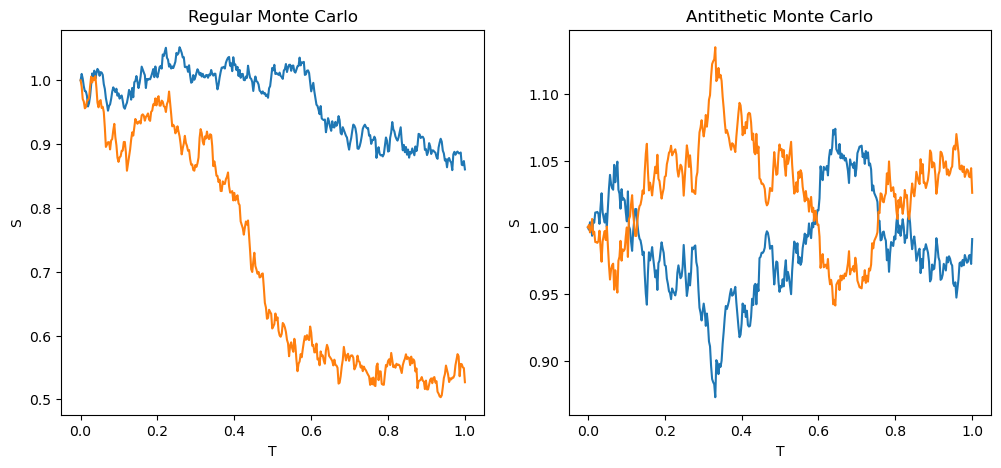

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Regular Monte Carlo")
plt.plot(mc_ts,paths[:,0,0])
plt.plot(mc_ts,paths[:,0,1])
plt.xlabel("T")
plt.ylabel("S")

plt.subplot(122)
plt.title("Antithetic Monte Carlo")
plt.plot(mc_ts,antithetic_paths[:,0,0])
plt.plot(mc_ts,antithetic_paths[:,0,1])
plt.xlabel("T")
plt.ylabel("S")


### Problem 1.6

For each asset $\alpha=1,2,3$ make a plot comparing the MC sampling error of plain  Monte Carlo and antithetic sampling for the estimation of 
$$
    \mathbb{E}[S_T]
$$
as a function of the expiry $T$



In [26]:
std=np.sqrt(paths.var(axis=-1)/npaths)
print(std.shape)
std_a=np.empty_like(std)
for t_idx,t in enumerate(mc_ts):
    for alpha in range(3):
        pay=antithetic_paths[t_idx,alpha]
        std_a[t_idx,alpha]=std_antithetic(pay)

(366, 3)


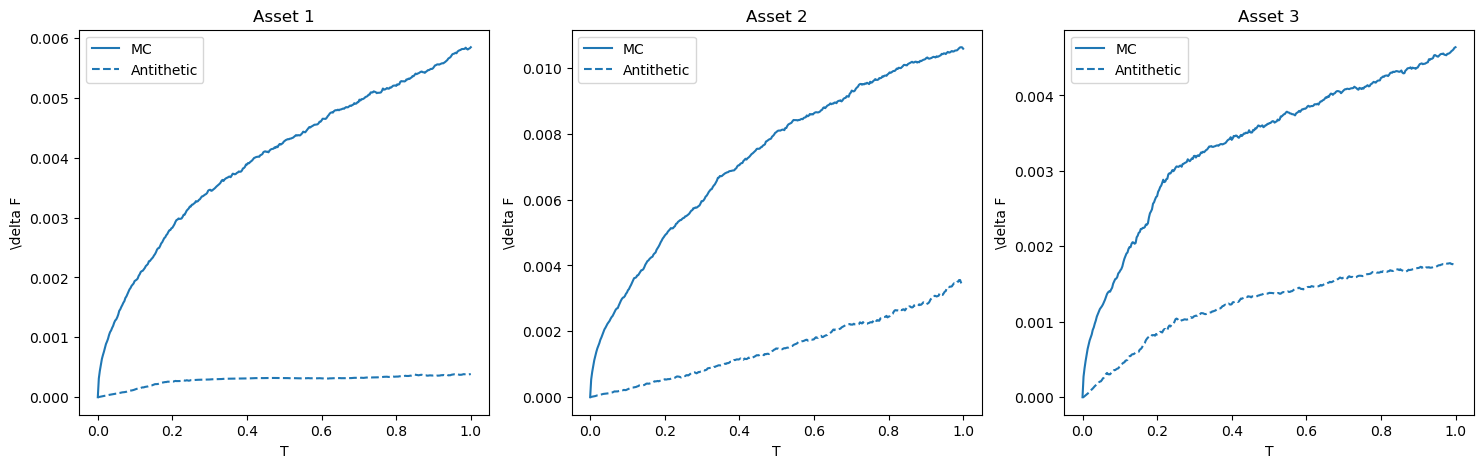

In [27]:
plt.figure(figsize=(18,5))
for alpha in range(3):
    plt.subplot(1,3,alpha+1)
    plt.title(f"Asset {alpha+1}")
    p=plt.plot(mc_ts,std[:,alpha],label="MC")
    color=p[0].get_color()
    plt.plot(mc_ts,std_a[:,alpha],color=color,linestyle="dashed",label="Antithetic")
    plt.xlabel("T")
    plt.ylabel("\delta F")
    plt.legend()

### Problem 1.7 

For each asset $\alpha=1,2,3$ make a plot comparing the MC sampling error of plain  Monte Carlo and antithetic sampling for the estimation of  for the At the Money Forward Call Option with payoff

$$
    \max( S_{\alpha,T} - F_{\alpha,T},0)
$$

In [28]:
std=np.empty((len(mc_ts),nvars))
std_a=np.empty((len(mc_ts),nvars))
for (t_idx,t) in enumerate(mc_ts):
    for alpha in range(nvars):
        F=fwds[alpha](t)
        pay=np.maximum(paths[t_idx,alpha]-F,0)
        pay_a=np.maximum(antithetic_paths[t_idx,alpha]-F,0)
        std[t_idx,alpha]=np.sqrt(pay.var()/npaths)
        std_a[t_idx,alpha]=std_antithetic(pay_a)

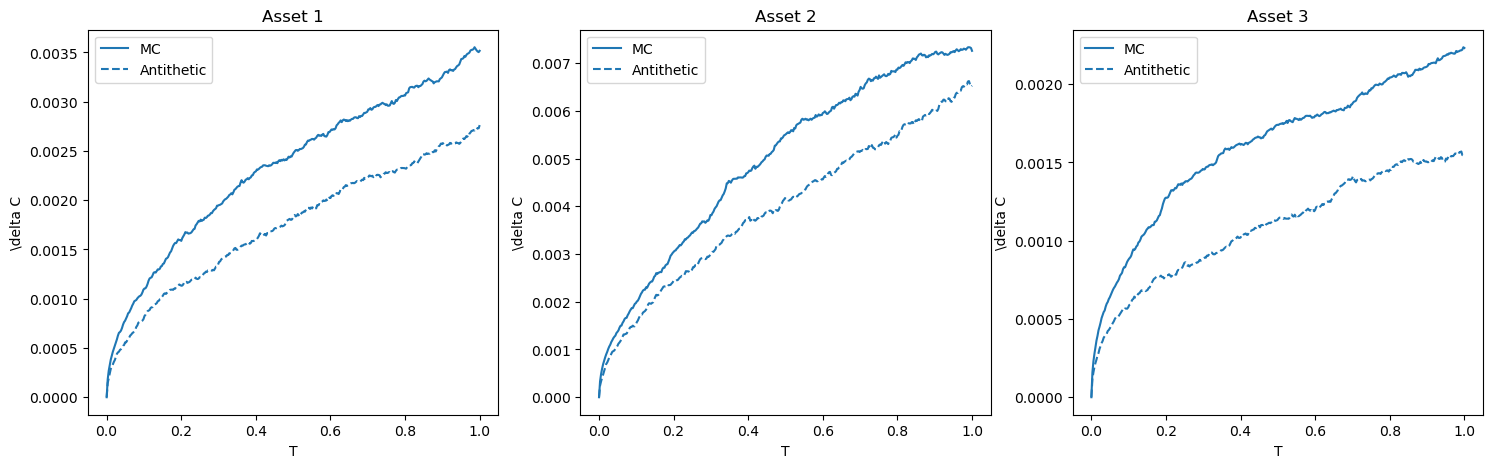

In [29]:
plt.figure(figsize=(18,5))
for alpha in range(3):
    plt.subplot(1,3,alpha+1)
    plt.title(f"Asset {alpha+1}")
    p=plt.plot(mc_ts,std[:,alpha],label="MC")
    color=p[0].get_color()
    plt.plot(mc_ts,std_a[:,alpha],color=color,linestyle="dashed",label="Antithetic")
    plt.xlabel("T")
    plt.ylabel("\delta C")
    plt.legend()

### Problem 1.8

For each asset $\alpha=1,2,3$ make a plot comparing the MC sampling error of plain  Monte Carlo and antithetic sampling for the estimation of  for the At the Money Forward **straddle** Option with payoff

$$
    \max( S_{\alpha,T} - F_{\alpha,T},0) + \max(F_{\alpha,T}- S_{\alpha,T} -,0)
$$

(A straddle is the sum of a put and a call option with the same strike)

In [30]:
std=np.empty((len(mc_ts),nvars))
std_a=np.empty((len(mc_ts),nvars))
for (t_idx,t) in enumerate(mc_ts):
    for alpha in range(nvars):
        F=fwds[alpha](t)
        pay=np.maximum(paths[t_idx,alpha]-F,0)+np.maximum(F-paths[t_idx,alpha],0)
        pay_a=np.maximum(antithetic_paths[t_idx,alpha]-F,0)+np.maximum(F-antithetic_paths[t_idx,alpha],0)
        std[t_idx,alpha]=np.sqrt(pay.var()/npaths)
        std_a[t_idx,alpha]=std_antithetic(pay_a)

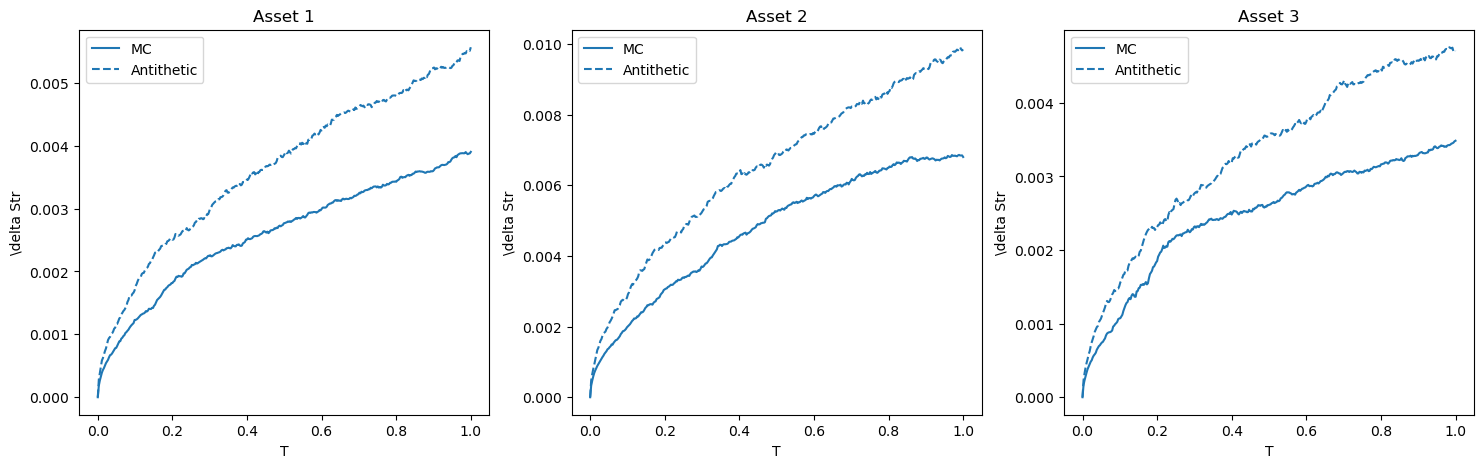

In [31]:
plt.figure(figsize=(18,5))
for alpha in range(3):
    plt.subplot(1,3,alpha+1)
    plt.title(f"Asset {alpha+1}")
    p=plt.plot(mc_ts,std[:,alpha],label="MC")
    color=p[0].get_color()
    plt.plot(mc_ts,std_a[:,alpha],color=color,linestyle="dashed",label="Antithetic")
    plt.xlabel("T")
    plt.ylabel("\delta Str")
    plt.legend()

### Problem 1.9 
Comment on the different in results between the Call option (Problem 1.7) and the Straddle (Problem 1.8).
Can you explain why?

<div class="alert alert-block alert-success"> 
    Antithetic sampling lowers variance for call options but <b>increases</b> it for the straddles.

This is because the Call option is an increasing payoff, so there is a negative correlation
between $f(\text{d}W)$ and $-f(\text{d}W)$. 
    
The straddle payoff, however, is symmetric around the forward $F$
and, therefore $f(\text{d}W)$ and $-f(\text{d}W)$ have positive correlation.
</div>

## Problem 2: Call on Worst of Asians

The payout of a worst of asian call is
$$
\text{call} = \max( W - K,0)
$$
where $W$ is the works of Asian averages
$$
        W = \min_{\alpha} A_\alpha
$$
and  $A_\alpha$ is the Asian average of asset $\alpha$ 
$$
    A_\alpha = \frac{1}{T}\sum_{t<T} S_{\alpha,t}
$$
### Problem 2.1

Using the Monte Carlo paths already generated price a One year, At the money forward,  Call Option on the Worst of Asian Averages (your implemented this payoff on Problem 3 or last homework).

Compare the Averages and Monte Carlo sampling errors for regular Monte Carlo and antithetic sampling.

[HINT] By At the Money forward for the Basket use the Average of the three asset Forwards

In [32]:
class CallWorstofAsiansPayoff:
    def __init__(self,strike,expiry):
        self.strike=strike
        self.expiry=expiry
        self.step=None
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[:self.step] # restict observation up to expiry
        m=s.mean(axis=0) # compute Asian mean for each asset
        w=m.min(axis=0) # compute work of means
        val=np.maximum(0.0,w-self.strike) # call on worst of means      
        return val

In [33]:
T=1
F1=fwds[0](T)
F2=fwds[1](T)
F3=fwds[2](T)
Fb=(F1+F2+F3)/3

In [34]:
worstof =CallWorstofAsiansPayoff(Fb,T)
worstof.set_steps(mc_ts)

In [35]:
pay=worstof(paths)
pay_a=worstof(antithetic_paths)

In [36]:
mc_price=pay.mean()
amc_price=pay_a.mean()
print("MC Price",mc_price)
print("Antithetics Price",amc_price)

MC Price 0.01225276414579205
Antithetics Price 0.01162107400882717


In [37]:
mc_std=np.sqrt(pay.var()/npaths)
amc_std=std_antithetic(pay_a)
print("MC std",mc_std)
print("Antithetics std",amc_std)

MC std 0.0008933201510016745
Antithetics std 0.0007183860530580858


### Problem 2.2
To approximate the exact value of the option, re-price the option using regular
Monte Carlo Sampling and 100_000 samples.

Are the MC mean and std error estimates you found in problem 2.1 consistent with this exact value? 

In [38]:
lpaths=propagate(process,S0,mc_ts,rng,100_000)

In [39]:
lpay=worstof(lpaths)
eprice=lpay.mean(),
eprice,np.sqrt(lpay.var()/100_000)

((0.01127791378879043,), 8.242674034420621e-05)

In [40]:
(mc_price-eprice)/mc_std

array([1.0912665])

In [41]:
(amc_price-eprice)/mc_std

array([0.38414024])

<div class="alert alert-block alert-success"> 

The distance between MC price and Exact price is within one standard deviation for or regular Monte Carlo and for Antithetic Sampling.

Antithetic sampling has a slightly reduced (80%) variance

</div>

In [42]:
amc_std/mc_std

0.8041753589153495

## Problem 3: Control Variates for Worst of Asian Call

### Problem 3.1 

Price again the  one year, At the money forward,  Call Option on the Worst of Asian Averages
using some control variates (you should select what you think are the most promissing control variates)

[HINT] There are many ways to perform a multivariate linear regression in python. For example, you could use [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html), but feel free to use which ever method you like best.

In [43]:
F=np.empty(nvars)
for alpha in range(nvars):
    F[alpha]=fwds[alpha](1)

In [44]:
X=np.empty((npaths,nvars+1))

In [45]:
X[:,0]=1
for alpha in range(3):
    X[:,alpha+1]=np.maximum(paths[-1,alpha,:]-F[alpha],0)

In [46]:
X.shape

(1000, 4)

In [47]:
fit=np.linalg.lstsq(X,pay,rcond=None)
theta=fit[0]
theta

array([-0.00417432,  0.06148762,  0.02933621,  0.16391927])

In [48]:
prices=np.empty(nvars+1)
prices[0]=1
for alpha in range(nvars):
    sig=vols[alpha](T,F[alpha])
    prices[alpha+1]=bs_price_fwd(True,F[alpha],T,F[alpha],sig)

In [49]:
cv_price=np.dot(prices,theta)
print("Control Variate Price",cv_price)

Control Variate Price 0.011965156113823518


### Problem 3.2

Estimate the sampling error of the control variate price. Is it lower or higher than 
the antithetic sampling estimate?

In [50]:
err=pay - np.dot(X,theta)

In [51]:
D=X.shape[1]
D

4

In [52]:
cv_std=np.sqrt(err.var()/(npaths-D))
print("Control Variate Std",cv_std)

Control Variate Std 0.0006403609347653903


In [53]:
(cv_price-eprice)/cv_std

array([1.07321088])

<div class="alert alert-block alert-success"> 
It has lower variance than the antithetic estimate.</div>

## Problem 4:  Control Variates for Worst of Asian Straddle

### Problem 4.1 

Implement an option payoff for a Worst of Asian **Straddle**:

$$
\text{straddle} = \max( W - K,0)+\max(K-W,0)
$$
where $W$ is the works of Asian averages
$$
        W = \min_{\alpha} A_\alpha
$$
and  $A_\alpha$ is the Asian average of asset $\alpha$ 
$$
    A_\alpha = \frac{1}{T}\sum_{t<T} S_{\alpha,t}
$$

In [54]:
class StraddleWorstofAsiansPayoff:
    def __init__(self,strike,expiry):
       pass
    def set_steps(self,ts):
        pass
    def __call__(self,paths):
        pass

In [55]:
class StraddleWorstofAsiansPayoff:
    def __init__(self,strike,expiry):
        self.strike=strike
        self.expiry=expiry
        self.step=None
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[:self.step] # restict observation up to expiry
        m=s.mean(axis=0) # compute Asian mean for each asset
        w=m.min(axis=0) # compute worst of means
        val=np.maximum(0.0,w-self.strike)+np.maximum(0.0,self.strike-w) # straddle on worst of means      
        return val

### Problem 4.2

Price again the  one year, At the money forward,  **straddle** on the Worst of Asian Averages
using some control variates (you should select what you think are the most promissing control variates)

Estimate the sampling error of the control variate price. Is it lower or higher than 
the antithetic sampling estimate?

[HINT] The best control variates for a straddle are different that a call option.

In [56]:
straddle =StraddleWorstofAsiansPayoff(Fb,T)
straddle.set_steps(mc_ts)

In [57]:
lpay=straddle(lpaths)
eprice=lpay.mean(),
eprice,np.sqrt(lpay.var()/100_000)

((0.10153949231261003,), 0.0003035276239129656)

In [58]:
pay=straddle(paths)

In [59]:
price=pay.mean()
std=np.sqrt(pay.var()/npaths)
print("MC price",price)
print("MC std",std)

MC price 0.09813033452953197
MC std 0.0030340778017870643


In [60]:
X=np.empty((npaths,nvars+1))

In [61]:
X[:,0]=1
for alpha in range(3):
    X[:,alpha+1]=np.maximum(paths[-1,alpha,:]-F[alpha],0)+np.maximum(F[alpha]-paths[-1,alpha,:],0)

In [62]:
fit=np.linalg.lstsq(X,pay,rcond=None)
theta=fit[0]
theta

array([0.03379231, 0.16312223, 0.02177118, 0.3748821 ])

In [63]:
prices=np.empty(nvars+1)
prices[0]=1
for alpha in range(nvars):
    sig=vols[alpha](T,F[alpha])
    prices[alpha+1]=bs_price_fwd(True,F[alpha],T,F[alpha],sig)+bs_price_fwd(False,F[alpha],T,F[alpha],sig)

In [64]:
cv_price=np.dot(prices,theta)
print("Control Variate Price",cv_price)

Control Variate Price 0.09884449410730496


In [65]:
err=pay - np.dot(X,theta)

In [66]:
D=X.shape[1]
D

4

In [67]:
cv_std=np.sqrt(err.var()/(npaths-D))
print("Control Variate Std",cv_std)

Control Variate Std 0.0026263924817063783


In [68]:
(cv_price-eprice)/cv_std

array([-1.02612166])

<div class="alert alert-block alert-success"> 
Control Variate estimate has lower variance than regular Monte Carlo.

Finding good control variates is subtle and require a good understanding on the 
payoff distribution along paths.
>
For example, in this case is better to use both <b>calls</b> and <b>puts</b>
as control variates instead of the stradle:
</div>

In [69]:
X=np.empty((npaths,2*nvars+1))

In [70]:
X[:,0]=1
for alpha in range(3):
    X[:,2*alpha+1]=np.maximum(paths[-1,alpha,:]-F[alpha],0)
    X[:,2*alpha+2]=np.maximum(F[alpha]-paths[-1,alpha,:],0)

In [71]:
fit=np.linalg.lstsq(X,pay,rcond=None)
theta=fit[0]
theta

array([0.02309561, 0.04827135, 0.23730566, 0.00984737, 0.26551234,
       0.13565812, 0.31843632])

In [72]:
prices=np.empty(2*nvars+1)
prices[0]=1
for alpha in range(nvars):
    sig=vols[alpha](T,F[alpha])
    prices[2*alpha+1]=bs_price_fwd(True,F[alpha],T,F[alpha],sig)
    prices[2*alpha+2]=bs_price_fwd(False,F[alpha],T,F[alpha],sig)

In [73]:
cv_price=np.dot(prices,theta)
print("Control Variate Price",cv_price)

Control Variate Price 0.10139893223326576


In [74]:
err=pay - np.dot(X,theta)

In [75]:
D=X.shape[1]
D

7

In [76]:
cv_std=np.sqrt(err.var()/(npaths-D))
print("Control Variate Std",cv_std)

Control Variate Std 0.0018981352708265782


In [77]:
(cv_price-eprice)/cv_std

array([-0.07405167])